# 사내 분실물 센터 객체 탐지 고도화 모델 개발

In [1]:
from IPython.display import Image as DisplayImage
DisplayImage(filename='figures/lost_and_found.png', width=500)

Output hidden; open in https://colab.research.google.com to view.

당신은 사내 분실물 센터 관리자이다.

과거 분실물 센터에서는 잃어버린 물건을 찾는 연락을 받으면 관리자가 해당 물건을 찾아보고 사진을 촬영해 본인의 물건이 맞는지 확인하는 방식으로 물건을 찾아주었다.

이 과정을 자동화하기 위해 접수된 물건을 사진으로 촬영해 저장하고 딥러닝 모델을 이용해 잃어버린 물건을 찾는 시스템을 개발하였다.

최근 무선 이어폰이 자주 분실되는데, 시스템을 개발할 당시에는 무선 이어폰이 출시되지 않았다. 무선 이어폰과 같이 새로운 물건에 대해서는 기존 시스템을 이용할 수 없다.

학습 시 사용되지 않은 객체에 대해서도 시스템을 활용할 수 있도록 시스템을 고도화하고자 한다.

In [11]:
!unzip figures.zip

Archive:  figures.zip
  inflating: figures/bbox2.png       
  inflating: figures/clip.png        
  inflating: figures/bbox.png        
  inflating: figures/window_stride_bigpatch_patch.png  
  inflating: figures/patches.png     
  inflating: figures/lost_and_found.png  


In [10]:
!mkdir data

In [81]:
!gdown 1Gx8FkfHcSyRNp_lSbYr5aD6cAPa82m2f -O data/
!gdown 1Q8U2sPDZUp9Km7fMzzjZM6VOoOT9Us1K -O data/
!gdown 1Rh0muR9gFbL_1JIo_yNMSNW75TockVda -O data/
!gdown 1UeQkKTi7OcLF-WocYYN27rCMulBuRCwz -O data/
!gdown 1YV9WAp90ZJsaAHy-Us0Qz99gYvtLNjUx -O data/
!gdown 1cY9M6dtcubHiWHmKlTjsUBL5ppwDJRe_ -O data/
!gdown 1u4N_kggUgWKcDgsVzEYKGndFRwDgLh1b -O data/
!gdown 1vLmR7PM1Q_5fZQ8b_CRzu_L6MSJRDbeu -O data/

Downloading...
From: https://drive.google.com/uc?id=1Gx8FkfHcSyRNp_lSbYr5aD6cAPa82m2f
To: /content/data/cls_4.jpg
100% 4.02M/4.02M [00:00<00:00, 188MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Q8U2sPDZUp9Km7fMzzjZM6VOoOT9Us1K
To: /content/data/det_3.jpg
100% 6.41M/6.41M [00:00<00:00, 12.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Rh0muR9gFbL_1JIo_yNMSNW75TockVda
To: /content/data/cls_3.jpg
100% 1.01M/1.01M [00:00<00:00, 136MB/s]
Downloading...
From: https://drive.google.com/uc?id=1UeQkKTi7OcLF-WocYYN27rCMulBuRCwz
To: /content/data/det_1.jpg
100% 3.01M/3.01M [00:00<00:00, 263MB/s]
Downloading...
From: https://drive.google.com/uc?id=1YV9WAp90ZJsaAHy-Us0Qz99gYvtLNjUx
To: /content/data/det_4.jpg
100% 1.25M/1.25M [00:00<00:00, 126MB/s]
Downloading...
From: https://drive.google.com/uc?id=1cY9M6dtcubHiWHmKlTjsUBL5ppwDJRe_
To: /content/data/det_2.jpg
100% 1.11M/1.11M [00:00<00:00, 161MB/s]
Downloading...
From: https://drive.google.com/uc?id=1u4N_kggUgWKcDgsVzEYKGn

In [2]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-j03isfes
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-j03isfes
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [3]:
from PIL import Image
import torch
import clip
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.transforms import CenterCrop, Compose, Normalize, Resize, InterpolationMode
import time
from IPython.display import Image as DisplayImage

필요하다면 [파이썬 표준 라이브러리](https://docs.python.org/3/library/index.html) 내 모듈이나 설치된 라이브러리를 임의로 불러올 수 있다.

In [4]:
import itertools, functools, collections # 기타 필요한 모듈 ...

과제를 풀기 위하여 `device` 가 `cuda` 로 잘 지정되었는지 확인한다.

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## 목차

**Ⅰ. 모델 준비**
    
**Ⅱ. 이미지 분류 (image classification) 태스크 수행**
    
**Ⅲ. 객체 인식 (object detection) 태스크 수행**


## Ⅰ. 모델 준비

CLIP (Contrastive Language-Image Pretraining) 모델은 대용량 데이터로 학습된 모델로 다양한 종류의 물체를 인식하는데 훌륭한 성능을 가진 모델이다.

학습시 고려하지 못한 물건도 인지할 수 있는 시스템을 개발하기 위해 사전 학습된 CLIP 모델을 이용하기로 결정했다.

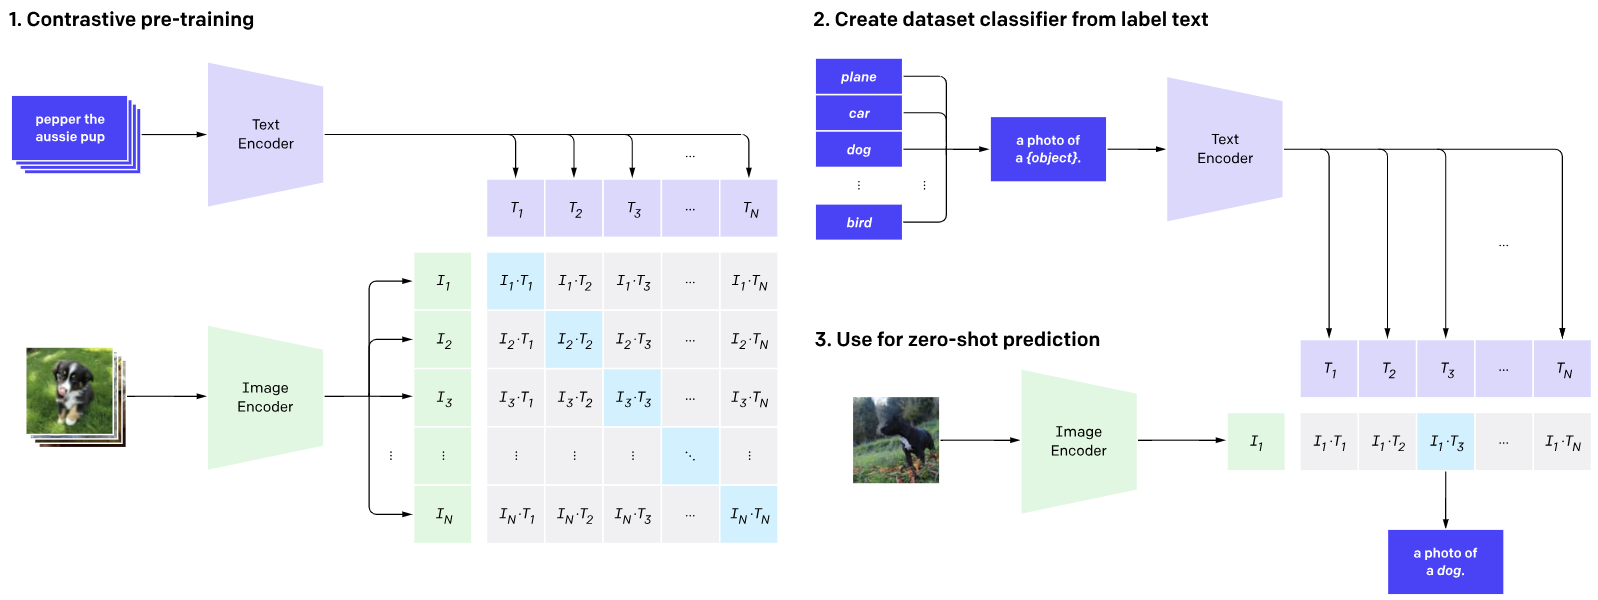

In [6]:
DisplayImage(filename='figures/clip.png', width=1000)

### **[이론 설명]**

**1. Contrastive pre-training**: CLIP의 이미지 인코더와 텍스트 인코더는 어떤 이미지가 어떤 텍스트와 짝을 이루었는지 예측하며 사전 학습된다.

Image classification 을 수행하기 위해 동일한 동작을 사용할 수 있다.

**2. Create dataset classifier from label text**: 데이터셋의 모든 클래스에 대하여 "a photo of a {class}" 와 같이 text prompt 를 생성한다.

**3. Use for zero-shot prediction**: 주어진 이미지와 가장 잘 짝을 이루는 class 를 선택한다.

아래 코드에서는 사전 학습된 CLIP 모델을 불러오고 모델의 입력으로 사용하기 위한 전처리 함수를 정의한다.

`img_preprocess` 는 `clip_preprocess` 에서 `transforms.ToTensor()` 를 제외한 전처리 함수이다.


In [7]:
clip_model, clip_preprocess = clip.load("ViT-B/32", device="cuda")

img_preprocess = Compose(
    [
        Resize(size=224, interpolation=InterpolationMode.BICUBIC, max_size=None, antialias=None), # 가로 세로 중 짧은 변을 224로 조정
        CenterCrop(size=(224, 224)), # 정사각형이 아닌 경우 가운데를 자름.
        Normalize(
            mean=(0.48145466, 0.4578275, 0.40821073),
            std=(0.26862954, 0.26130258, 0.27577711),
        ),
    ]
)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 147MiB/s]


## Ⅱ. Image classification 수행

### **[상황 설명]**

접수된 각각의 분실물에 대하여 사진을 한 장씩 촬영하였다.

이미지 분류 (image classification) 태스크를 통해 사진 속 물건의 이름을 자동으로 레이블링하고자 한다.

### **[문제 설명] 추론 코드 구현 **
CLIP 을 이용해 image classification 을 수행하는 코드를 완성하여라.

* `probs` 는 classes 에 대한 주어진 이미지의 확률값이다.
* `pred` 는 `probs` 기반으로 구한 모델의 예측값 (클래스) 이다.

답안 제출 방법 및 채점 기준은 다음과 같다.
* 주어진 4장의 사진에 대하여 classification 을 수행하고 예측 결과 및 확률값을 답안으로 제출하여라.
* 예측 결과 및 확률값이 정답과 일치할 경우 정답 처리한다.

In [25]:
sample_text = "Hello, World!"
tokenized = clip.tokenize([sample_text])
print(tokenized)

tensor([[49406,  3306,   267,  1002,   256, 49407,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)


In [26]:
def zero_shot_classification(img_dir, classes):
    image = Image.open(img_dir)
    image = clip_preprocess(image)
    image = image.unsqueeze(0).to(device) # batch dimension 추가
    classes = ["fox", "bear", "seagull", "owl"]
    text = clip.tokenize(classes).to(device)

    with torch.no_grad():
        logits_per_image, logits_per_text = clip_model(image, text)
        print(logits_per_image.shape)
        print(logits_per_text.shape)
        # ================================================================== #
        #         START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)        #
        # ================================================================== #
        probs = logits_per_image.softmax(dim=-1)
        pred = probs.argmax().item()
        # ================================================================== #
        #         END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)        #
        # ================================================================== #

    probs = probs.cpu().numpy()
    pred = classes[pred]

    print("Label probs:", probs)
    print("Prediction:", pred)

    return probs, pred

### **[답안 검증]**

아래 셀을 실행하여 아래와 같은 답이 나오는지 확인한다.

```
Label probs: [[3.535e-05 3.266e-05 2.165e-04 9.995e-01]]
Prediction: owl
```

In [27]:
img_dir = 'data/cls_1.jpg'
classes = ["fox", "bear", "seagull", "owl"]
zero_shot_classification(img_dir, classes)

torch.Size([1, 4])
torch.Size([4, 1])
Label probs: [[3.535e-05 3.219e-05 2.165e-04 9.995e-01]]
Prediction: owl


(array([[3.535e-05, 3.219e-05, 2.165e-04, 9.995e-01]], dtype=float16), 'owl')

### **[답안 확인]**

In [29]:
ans = []
classes = ["fox", "bear", "seagull", "owl"]
cls_img_dirs = [f'data/cls_{i+1}.jpg' for i in range(4)]
for img_dir in cls_img_dirs:
    probs, pred = zero_shot_classification(img_dir, classes)
    ans.append((pred, probs[0]))

print(ans)

torch.Size([1, 4])
torch.Size([4, 1])
Label probs: [[3.535e-05 3.219e-05 2.165e-04 9.995e-01]]
Prediction: owl
torch.Size([1, 4])
torch.Size([4, 1])
Label probs: [[3.350e-04 9.990e-01 4.954e-04 3.350e-04]]
Prediction: bear
torch.Size([1, 4])
torch.Size([4, 1])
Label probs: [[1.000e+00 3.272e-05 7.153e-07 2.795e-05]]
Prediction: fox
torch.Size([1, 4])
torch.Size([4, 1])
Label probs: [[8.941e-07 2.742e-06 1.000e+00 6.604e-05]]
Prediction: seagull
[('owl', array([3.535e-05, 3.219e-05, 2.165e-04, 9.995e-01], dtype=float16)), ('bear', array([3.350e-04, 9.990e-01, 4.954e-04, 3.350e-04], dtype=float16)), ('fox', array([1.000e+00, 3.272e-05, 7.153e-07, 2.795e-05], dtype=float16)), ('seagull', array([8.941e-07, 2.742e-06, 1.000e+00, 6.604e-05], dtype=float16))]


## Ⅲ. Object detection 수행

회사의 규모가 커짐에 따라 사원의 수가 증가하고, 관리해야 하는 분실물의 수도 함께 증가하였다.

모든 분실물에 대하여 하나씩 사진을 촬영하는데 소요되는 시간을 단축하고자 여러 물체를 한 번에 촬영하고 그 중에 찾고자 하는 물건이 있는지 찾고자 한다. 이에 따라, 객체 탐지 (object detection) 태스크를 이용하고자 한다.

### **[이론 설명]**

Object detection 은 찾고자 하는 클래스가 이미지 내 어떤 곳에 위치해 있는지 찾는 태스크이다.

주어진 이미지를 작은 patch 로 나누어 patch 별로 찾고자 하는 클래스와의 유사도를 계산함으로써 CLIP 을 활용해 object detection 을 수행할 수 있다.

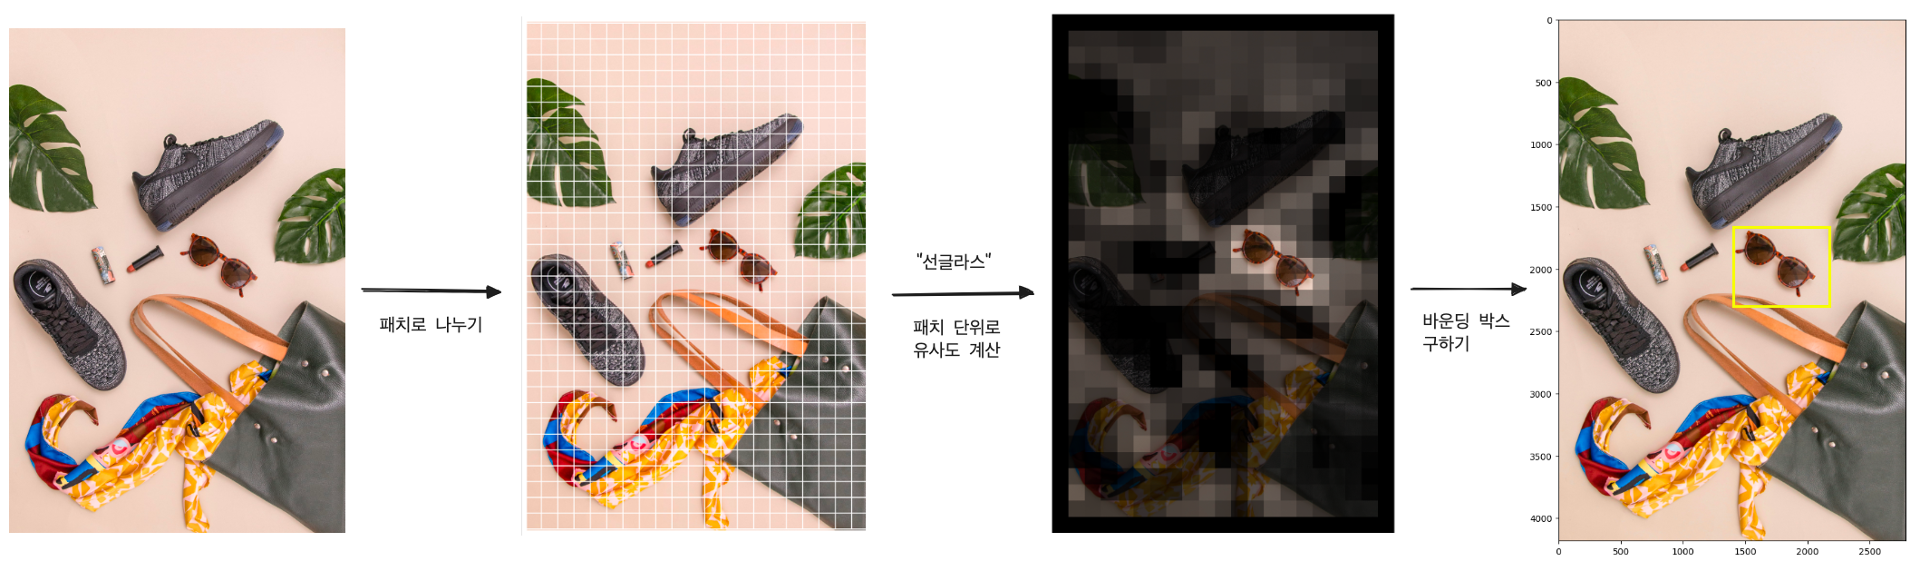

In [30]:
DisplayImage(filename='figures/bbox.png', width=1000)

### **[문제 설명] Patch 구성하기**

`(C, H, W)` 크기로 주어지는 이미지를 height 와 width 가 모두 `patch` (예: 256) 인 작은 이미지로 나누는 코드 `create_patches` 를 완성하시오.

이 함수는 `(1, H//patch, W//patch, C, patch, patch)` 사이즈를 갖는 `patches` 를 반환한다.

힌트: [`torch.Tensor.unfold(dimension, size, step)`](https://pytorch.org/docs/stable/generated/torch.Tensor.unfold.html) 참고.

* 주어진 이미지에 대하여 패치를 구하고, 패치 크기를 답안으로 제출하여라.
* 모든 이미지에 대하여 정답 패치 크기와 동일할 경우 정답 처리한다.

In [35]:
image_tensor = torch.rand(3, 427, 640)
patches = image_tensor.data.unfold(0, 3, 3)
patches.shape

torch.Size([1, 427, 640, 3])

In [46]:
import torch

def create_patches(image_tensor, patch=128, print_patch_size=False):
    # image_tensor: torch.Size([3, 427, 640])

    # permute로 채널을 맨 뒤로 보냄 (C, H, W) -> (H, W, C)
    patches = image_tensor.permute(1, 2, 0)
    if print_patch_size:
        print(patches.shape)  # torch.Size([427, 640, 3])

    # unfold로 높이 차원에서 패치 생성
    patches = patches.unfold(0, patch, patch)
    if print_patch_size:
        print(patches.shape)  # torch.Size([3, 640, 3, 128])

    # unfold로 너비 차원에서 패치 생성
    patches = patches.unfold(1, patch, patch)
    if print_patch_size:
        print(patches.shape)  # torch.Size([3, 5, 3, 128, 128])

    # (1, H//patch, W//patch, C, patch, patch)으로 reshape
    patches = patches.unsqueeze(0)

    return patches

### **[답안 검증]**

아래 셀을 실행하여 주어진 사진 cls_1.jpg 를 작은 패치로 나누고 아래와 같은 출력이 나오는지 확인한다.

```
original image size: torch.Size([3, 427, 640])
patches size: torch.Size([1, 3, 5, 3, 128, 128])
```

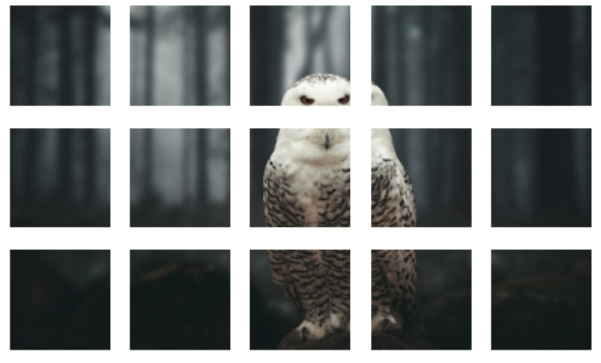

In [32]:

DisplayImage(filename='figures/patches.png')

torch.Size([427, 640, 3])
torch.Size([3, 640, 3, 128])
torch.Size([3, 5, 3, 128, 128])
original image size: torch.Size([3, 427, 640])
patches size: torch.Size([1, 3, 5, 3, 128, 128])


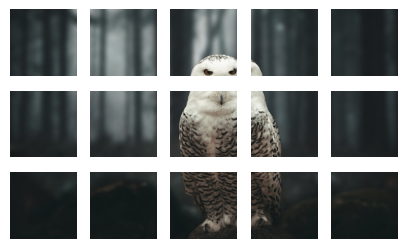

In [53]:
image = Image.open('data/cls_1.jpg')
transt = transforms.ToTensor()
image_tensor = transt(image)
patches = create_patches(image_tensor, patch=128, print_patch_size=True)

print(f'original image size: {image_tensor.size()}')
print(f'patches size: {patches.size()}')

def plot_patches(patches):
    fig, axs = plt.subplots(patches.size(1), patches.size(2), figsize=(5, 3))

    for i in range(patches.size(1)):
        for j in range(patches.size(2)):
            patch = patches[0, i, j].permute(1, 2, 0)
            axs[i, j].imshow(patch)
            axs[i, j].axis('off')

    plt.show()

plot_patches(patches)

### **[이론 설명]**

`compute_score` 함수는 주어진 이미지를 패치화하고, 각 패치에 대하여 주어진 classes 와의 유사도를 계산한다.

이때, `(C, patch, patch)` 크기의 patch 각각마다 유사도를 계산하는 것이 아니라, 패치들의 그룹인 `big_patch`와  classes 간 유사도를 계산한다.
`big_patch`는 가로 및 세로 방향으로 patch를 window 개수만큼 합쳐서 만들어지며 `(patch * window, patch * window, C)` 크기를 가진다.

`big_patch` 는 `stride` 크기 만큼 이미지를 슬라이딩하며 만들어진다.

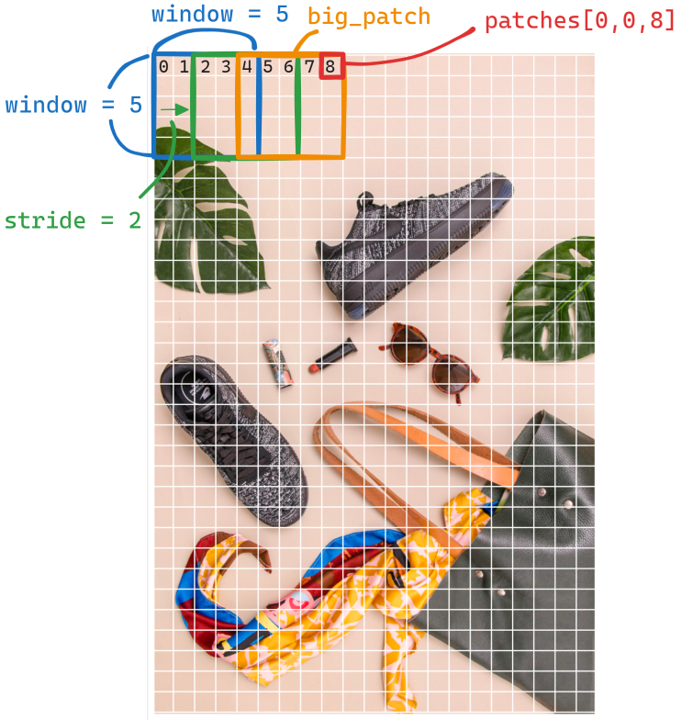

In [62]:
DisplayImage(filename='figures/window_stride_bigpatch_patch.png', width=600)

### **[문제 설명] Patch 단위로 유사도 계산하여 객체 탐지 수행하기**

 * `score`: 최종 bounding box 를 구하는데 사용할 score 값이다. `big_patch`와 `classes` 간 유사도를 이용한다.

 `score` 값은 `big_patch` 를 구성하는데 사용된 모든 patches 에 동일하게 사용된다.

 즉, `scores[Y : Y + window, X : X + window] += score` 와 같이 `window * window` 개수 만큼의 patches 에 대하여 동일한 score 값이 더해진다.

In [100]:
def compute_score(image_tensor, classes, img_preprocess, patch=256, window=2, stride=1):
    patches = create_patches(image_tensor, patch=patch)
    print("Patch shape: ", patches.shape)
    n_rows, n_cols = patches.shape[1], patches.shape[2]

    # 누적해서 기록될 scores 와 총 몇 번 더해졌는지 저장할 runs 선언
    scores = torch.zeros(n_rows, n_cols)
    runs = torch.ones(n_rows, n_cols)

    for Y in range(0, n_rows - window + 1, stride):
        for X in range(0, n_cols - window + 1, stride):
            big_patch = torch.zeros(patch * window, patch * window, 3)
            patch_batch = patches[0, Y : Y + window, X : X + window]
            for y in range(window):
                for x in range(window):
                    big_patch[
                        y * patch : (y + 1) * patch, x * patch : (x + 1) * patch, :
                    ] = patch_batch[y, x].permute(1, 2, 0)


            # big_patch 를 CLIP 의 이미지 입력으로 사용하기 위한 전처리
            input_image = img_preprocess(big_patch.permute(2, 0, 1).unsqueeze(0)).cuda()
            # classes 를 CLIP 의 텍스트 입력으로 사용하기 위한 전처리
            input_text = clip.tokenize(classes).cuda()

            with torch.no_grad():
                logits_per_image, logits_per_text = clip_model(
                    input_image, input_text
                )

            # ================================================================== #
            #         START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)        #
            # ================================================================== #

            if len(classes) > 1:
                score = torch.softmax(logits_per_image, dim=-1)[0][0].item()

            elif len(classes) == 1:
                score = logits_per_image.item()

            # ================================================================== #
            #         END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)          #
            # ================================================================== #

            # 이전 big patches 에서 계산한 scores 에 합산
            scores[Y : Y + window, X : X + window] += score
            runs[Y : Y + window, X : X + window] += 1

    return scores, runs, patches


### **[답안 검증]**
주어진 사진 'det_1.jpg' 에서 'sunglasses' 를 찾도록 아래 셀을 실행하여 바운딩 박스를 구한다.

* 힌트: class 는 list 형태로 주어지며, 찾고자 하는 클래스 하나만 입력으로 줄 수도 있고, 유사도를 계산하는데 유용한 다른 클래스를 함께 입력으로 줄 수 있다.

아래와 같은 바운딩 박스가 출력되는지 확인한다.
```
{'y_min': 1664, 'y_max': 2176, 'x_min': 1408, 'x_max': 2048}
```

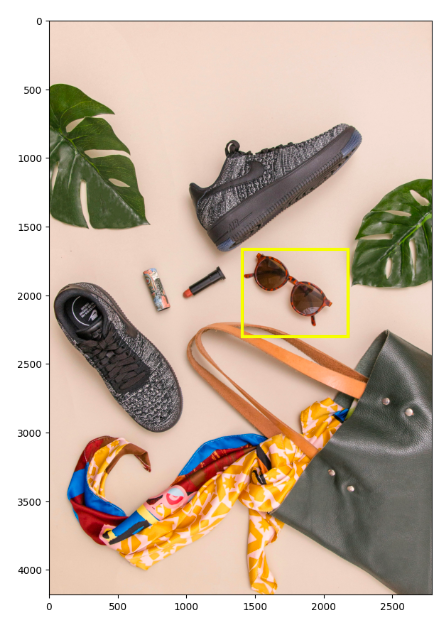

In [96]:
DisplayImage(filename='figures/bbox2.png')

In [101]:
# Bbox를 score에 따라 highlight하는 utility function. SKIP
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib


def plot_patches_with_scores(patches, scores, runs):
    normalized_scores = scores / runs
    normalized_scores = np.clip(normalized_scores-normalized_scores.mean(), 0, np.inf)
    normalized_scores = (
        normalized_scores - normalized_scores.min()) / (normalized_scores.max() - normalized_scores.min()
    )

    adj_patches = patches.squeeze(0).permute(3, 4, 2, 0, 1)
    adj_patches = adj_patches * normalized_scores
    adj_patches = adj_patches.permute(3, 4, 2, 0, 1)

    Y = adj_patches.shape[0]
    X = adj_patches.shape[1]

    fig, ax = plt.subplots(Y, X, figsize=(X*.5, Y*.5))
    for y in range(Y):
        for x in range(X):
            ax[y, x].imshow(adj_patches[y, x].permute(1, 2, 0))
            ax[y, x].axis("off")
            ax[y, x].set_aspect('equal')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

    return normalized_scores


def plot_bounding_box(image_tensor, normalized_scores, n_rows, n_cols, threshold=0.5, patch=256):
    detection = normalized_scores > threshold
    np.nonzero(detection)

    y_min, y_max = (
        np.nonzero(detection)[:,0].min().item(),
        np.nonzero(detection)[:,0].max().item()+1
    )

    x_min, x_max = (
        np.nonzero(detection)[:,1].min().item(),
        np.nonzero(detection)[:,1].max().item()+1
    )

    y_min *= patch
    y_max *= patch
    x_min *= patch
    x_max *= patch

    height = y_max - y_min
    width = x_max - x_min

    image_plot = np.moveaxis(image_tensor.data.numpy(), 0, -1)
    fig, ax = plt.subplots(figsize=(n_rows*0.5, n_cols*0.5))
    ax.imshow(image_plot)
    rect = matplotlib.patches.Rectangle(
        (x_min, y_min), width, height,
        linewidth=3, edgecolor='#FAFF00', facecolor='none'
    )
    ax.add_patch(rect)

    plt.show()

    return {"y_min": y_min, "y_max": y_max, "x_min": x_min, "x_max": x_max}

In [102]:
def zs_object_detection(img_dir, classes, patch, threshold):
    start = time.time()
    image = Image.open(img_dir)
    transt = transforms.ToTensor()
    image_tensor = transt(image)
    print("Start computing scores")
    scores, runs, patches = compute_score(image_tensor, classes, img_preprocess, patch=patch)
    print("Plot image with scores")
    normalized_scores = plot_patches_with_scores(patches, scores, runs)
    bbox = plot_bounding_box(image_tensor,
                  normalized_scores,
                  n_rows=patches.shape[1], n_cols=patches.shape[2],
                  threshold=threshold, patch=patch)
    print(bbox)
    end = time.time()
    print(f'Total time: ', time.strftime('%H:%M:%S', time.localtime(end - start)))
    return bbox

Start computing scores
Patch shape:  torch.Size([1, 32, 21, 3, 128, 128])
Plot image with scores


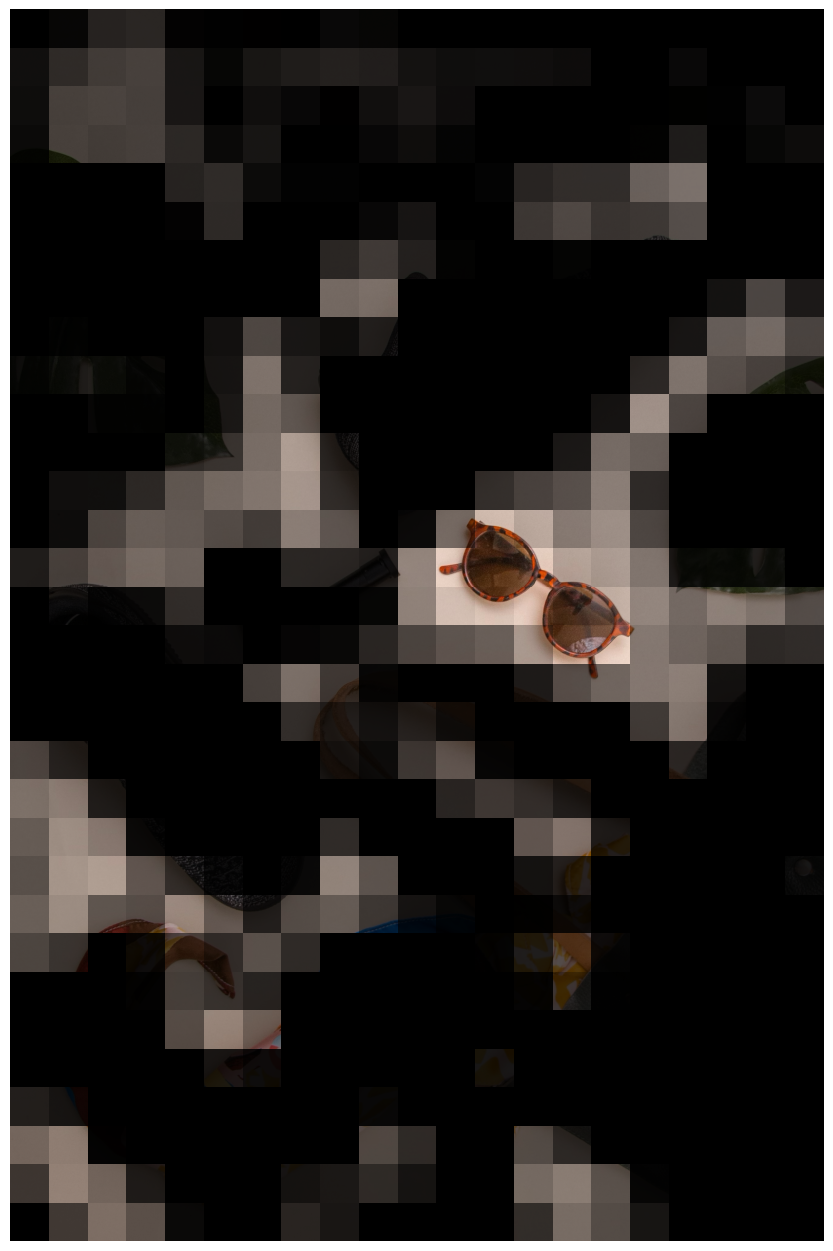

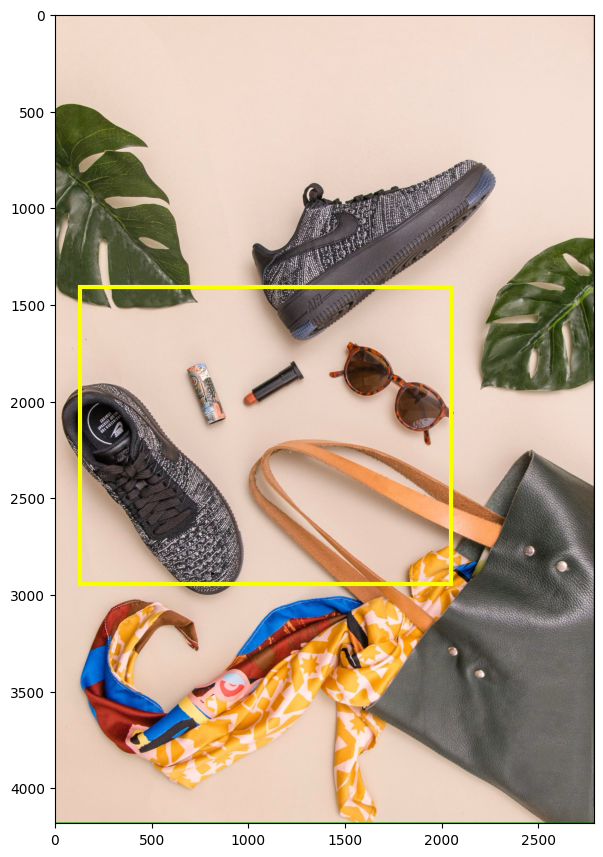

{'y_min': 1408, 'y_max': 2944, 'x_min': 128, 'x_max': 2048}
Total time:  00:00:33


{'y_min': 1408, 'y_max': 2944, 'x_min': 128, 'x_max': 2048}

In [103]:
zs_object_detection('data/det_1.jpg', ['sunglasses', "cons"], patch=128, threshold=0.7)

? 로 비워진 customized_class_list, customized_patch_list, customized_threshold_list 를 직접 완성하여 답안을 제출하여라.


* 사진 1장 당 예상 소요시간: 20초 내외

In [104]:
det_img_dirs_target = [
    ('data/det_2.jpg', 'sunglasses'),
    ('data/det_2.jpg', 'book'),
    ('data/det_3.jpg', 'tie'),
    ('data/det_3.jpg', 'shoes'),
    ('data/det_4.jpg', 'sunglasses'),
    ('data/det_4.jpg', 'keys'),
]

In [105]:
# ================================================================== #
#         START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)        #
# ================================================================== #

customized_classes_list = [ # 첫 번째 단어는 찾고자 하는 class, 이 외에는 오답들.
    ['sunglasses', 'bag', 'background'],
    ['book', 'bag', 'background'],
    ['tie', 'shoes', 'background'],
    ['shoes', 'background'],
    ['sunglasses', 'book', 'laptop', 'background'],
    ['keys', 'cable', 'pen', 'background'],
]
customized_patch_list = [128, 256, 256, 256, 128, 256]
customized_threshold_list = [0.8, 0.7, 0.7, 0.7, 0.5, 0.7]

# ================================================================== #
#         END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)          #
# ================================================================== #

In [106]:
ans = []
for (img_dir, _), classes, patch, threshold in zip(det_img_dirs_target, customized_classes_list, customized_patch_list, customized_threshold_list):
    bbox = zs_object_detection(img_dir, classes, patch=patch, threshold=threshold)
    ans.append(bbox)

print(ans)

Output hidden; open in https://colab.research.google.com to view.